<a href="https://colab.research.google.com/github/yusufunlu/DeepLearningExamples/blob/main/Testing_Evaluation_eff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Important Imports

In [ ]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import confusion_matrix
from keras.models import load_model

Mount colab to parent of Google Drive, so we can reach to project's folder and Google Drive which refers to all the folders I have

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This should json file to not expose my credentials

In [ ]:
os.environ['KAGGLE_USERNAME'] = "yusufunlu" # username from the json file
os.environ['KAGGLE_KEY'] = "6d464cc201a36e8743ed8fbaa39b235f" # key from the json file

Data is stored on Kaggle so downloading from kaggle to colab is better than downloading the user's machine and upload it because user's internet is probably slower than colab. On the other hand it is better for automation and escaping from errors. Lastly this method create reproducible codes

In [ ]:
!kaggle datasets download -d hgunraj/covidxct

100% 28.7G/28.7G [03:45<00:00, 193MB/s]
100% 28.7G/28.7G [03:45<00:00, 136MB/s]


Data is stored as zip file on kaggle. On the other hand "!" means that it is linux command not a python function

In [ ]:
!unzip covidxct.zip

We shouldn't be using magic numbers and magic strings in code for managing those variables and external configurations. File is downloaded into project's root folder in our case which is an upper level of 'MyDrive' folder

In [ ]:
dataset_path= '.'

Below functions used to be in extenal python file then I moved them into this notebook.

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
SEED =12

def load_labels(label_file):
    """Loads image filenames, classes, and bounding boxes"""
    fnames, classes, bboxes = [], [], []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            #typical line is like "NCP_341_1834_0022.png 2 0 130 512 429"
            #clean "\n" character from line(it doesn't change original line of file)
            #split the line into chunks, default delimiter is " " space character
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            #As an example below
            #fname=NCP_341_1834_0022.png,cls=2,xmin=0,ymin=130,xmax=512,ymax=429
            fnames.append(fname)
            classes.append(int(cls))
            bboxes.append((int(xmin), int(ymin), int(xmax), int(ymax)))
    #Below line was different as including windows dataset path in original code
    #by dataset_path it is externalized
    #fnames include path+filename not only file names
    fnames = [dataset_path + "/2A_images/" + fname for fname in fnames]
    #create and numy array
    fnames = np.array(fnames)
    classes = np.array(classes)
    #return 3 values as tuple
    return fnames, classes, bboxes
def index_generator(fnames , SET):
    """Generated random index of a particular class"""
    np.random.seed(SEED)
    index = np.random.randint(1,len(fnames),size = SET)
    return index 
def numberofclasses(classes, index):
    class0 = len((np.where(classes[index]==0))[0])
    class1 = len((np.where(classes[index]==1))[0])
    class2 = len((np.where(classes[index]==2))[0])
    return class0  , class1, class2
def dataframe_generator(test_index ,classes_test ):
    """Returns 1 dataframes of datasets distribution"""
    index = ["Normal" , "Pneumonia" , "COVID -19"]
    test_DF = numberofclasses(classes_test, test_index)
    #"Normal","Pneumonia","COVID -19" used as index
    df = pd.DataFrame({'test': test_DF } , index = index)
    return df
def data_constructor(filepath, classes , dim_size ,index  ,bboxes , interpolation = cv2.INTER_AREA , intensify =False):
    """Constructs and splits X and Y for training , validtion and test"""
    np.random.seed(SEED)
    y = np.array(classes[index])
    x = []
    for i in index:
        img  = cv2.imread(filepath[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x1,y1,x2,y2 = bboxes[i]
        img = img[y1:y2,x1:x2]
        img = cv2.resize(img, dim_size , interpolation = interpolation)
        x.append(img)
    
    x = np.array(x)
    if intensify == True:
        x= x/255
    return x , y 
def phase1_labels_updater(dense_y):
    """
    Updates labels for Phase-1 testing
    """
    for i in range(len(dense_y)):
        if dense_y[i] == 2:
            dense_y[i] =1 
        elif dense_y[i]==1:
            dense_y[i] = 0 
    return dense_y    
def index_extractor(y_preds, y_test,  test_index ,classes_test):
    """
    Extracts indexs of all the Original classes and Predicted classes by Phase-1 Model 
    """
    yclass_0 = np.where(y_preds==0)[0]
    yclass_1 = np.where(y_preds==1)[0]
    class_0 = np.where(y_test==0)[0]
    class_1 = np.where(y_test==1)[0]
    yclass0 = test_index[yclass_0]
    yclass1 = test_index[yclass_1]
    class0 = test_index[class_0]
    class1 =test_index[class_1]
    y00=np.where(classes_test[yclass0]==0)[0]
    y01=np.where(classes_test[yclass0]==1)[0]
    y02=np.where(classes_test[yclass0]==2)[0]
    y20=np.where(classes_test[yclass1]==0)[0]
    y21=np.where(classes_test[yclass1]==1)[0]
    index_00 = yclass0[y00]
    index_01 = yclass0[y01]
    index_02 = yclass0[y02]
    index_20 = yclass1[y20]
    index_21 = yclass1[y21]
    index_0 = np.concatenate((index_00,index_01))
    return index_0,index_02,index_20,index_21
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
      This function prints and plots the confusion matrix.
    """
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Setting up parameters and directories

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
DIM = (128,128)
TEST_SET= 25658
SEED=12 
label_file_test = dataset_path+"/test_COVIDx_CT-2A.txt"

In [ ]:
label_file_test

'./test_COVIDx_CT-2A.txt'

In [ ]:
!ls -la /content/drive/MyDrive/Colab\ Notebooks

total 532
-rw------- 1 root root  77622 Apr 29 21:59 'Copy of Phase-1.ipynb'
-rw------- 1 root root 376892 Apr 29 22:32 'Copy of Phase-2.ipynb'
-rw------- 1 root root  88766 Apr 29 22:31 'Copy of Testing_Evaluation.ipynb'
-rw------- 1 root root    306 Apr 29 22:29  Untitled


## Loading test data

FINAL IMAGE COUNT:
Total Test Images =  25658
test    12117
Name: Normal, dtype: int64


,test
Normal,12117
Pneumonia,7571
COIVD -19,5970


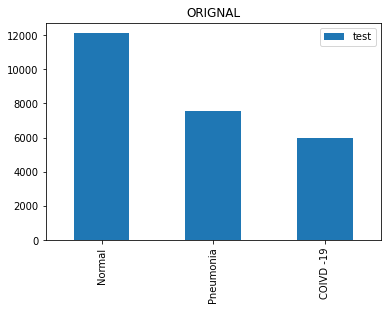

In [ ]:
fnames_test , classes_test , bboxes_test = load_labels(label_file_test)
test_index = index_generator(fnames_test , TEST_SET)
df = dataframe_generator(test_index,classes_test)
df.plot.bar( title = "ORIGNAL" );
print("FINAL IMAGE COUNT:")
print("Total Test Images = ",len(test_index))
print(df.loc["Normal"])
df.loc[:]

### Loading images for Phase - 1 testing

In [ ]:
densenet_x, densenet_y = data_constructor(fnames_test,classes_test, DIM , index  =test_index , bboxes = bboxes_test)
densenet_x = tf.keras.applications.densenet.preprocess_input(densenet_x)
desnenet_y = phase1_labels_updater(densenet_y)
densenet_x.shape , densenet_y.shape

((25658, 128, 128, 3), (25658,))

### Loading Phase-1 Trained Model

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/phase-1.h5 .

In [ ]:
!ls ./

2A_images     metadata.csv  test_COVIDx_CT-2A.txt
covidxct.zip  phase-1.h5    train_COVIDx_CT-2A.txt
drive	      sample_data   val_COVIDx_CT-2A.txt


In [ ]:
!wget https://github.com/sanskar-hasija/COVID-19_Detection/blob/main/models/phase-1.h5
!ls

--2022-04-30 00:11:50--  https://github.com/sanskar-hasija/COVID-19_Detection/blob/main/models/phase-1.h5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘phase-1.h5.1’

phase-1.h5.1            [ <=>                ] 127.33K  --.-KB/s    in 0.04s   

2022-04-30 00:11:50 (3.36 MB/s) - ‘phase-1.h5.1’ saved [130382]

2A_images     metadata.csv  sample_data		    val_COVIDx_CT-2A.txt
covidxct.zip  phase-1.h5    test_COVIDx_CT-2A.txt
drive	      phase-1.h5.1  train_COVIDx_CT-2A.txt


In [ ]:
!ls -la /content/drive/MyDrive/Colab\ Notebooks

total 73703
-rw------- 1 root root    79277 Apr 29 22:40 'Copy of Phase-1.ipynb'
-rw------- 1 root root   378201 Apr 29 23:06 'Copy of Phase-2.ipynb'
-rw------- 1 root root   105654 Apr 30 00:15 'Copy of Testing_Evaluation.ipynb'
-rwx------ 1 root root 74907480 Apr 30 00:14  phase-1.h5
-rw------- 1 root root      306 Apr 29 22:29  Untitled


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/phase-1.h5 .

In [ ]:
phase1_model = tf.keras.models.load_model("phase-1.h5")
densenet = phase1_model.evaluate(densenet_x, densenet_y)

802/802 [==============================] - 1822s 2s/step - loss: 0.0972 - accuracy: 0.9839


### Predicting NON-COVID and COVID-19

In [ ]:
densenet_preds = phase1_model.predict(densenet_x)
densenet_preds = np.rint(densenet_preds).astype("int")
densenet_preds= densenet_preds.reshape(TEST_SET)

## CONFUSION MATRIX of PHASE -1 

[[19537   151]
 [  261  5709]]


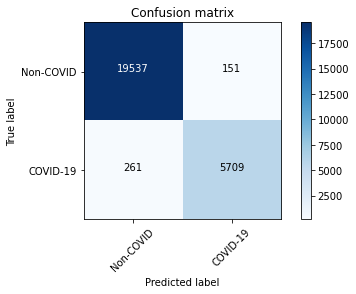

In [ ]:
cm1 = confusion_matrix(densenet_y ,densenet_preds)
plot_confusion_matrix(cm1,["Non-COVID","COVID-19"] )

#261 covid but we estimated wrong and 151 non-covid but predicted wrong 

### Extracting index for Phase-2 Testing

In [ ]:
index_0,index_02,index_20,index_21 = index_extractor(densenet_preds, densenet_y,  test_index ,classes_test)

### Passing True Positive from result of Phase-1 Testing to Phase-2 model

In [ ]:
inception_x, inception_y = data_constructor(fnames_test,classes_test, DIM , index  =index_0 , bboxes = bboxes_test)
inception_x = tf.keras.applications.inception_v3.preprocess_input(inception_x)
inception_x.shape , inception_y.shape

NameError: ignored

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/eff-2.h5 .

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/eff-2.h5': No such file or directory


In [ ]:
!ls

2A_images     metadata.csv  sample_data		    val_COVIDx_CT-2A.txt
covidxct.zip  phase-1.h5    test_COVIDx_CT-2A.txt
drive	      phase-2.h5    train_COVIDx_CT-2A.txt


In [ ]:
phase2_model = tf.keras.models.load_model("eff-2.h5")
inception = phase2_model.evaluate(inception_x , inception_y)

611/611 [==============================] - 546s 891ms/step - loss: 8.4858e-04 - accuracy: 0.9998


### Predicting Normal and Pnumonia 

In [ ]:
inception_preds = phase2_model.predict(inception_x)
inception_preds = np.rint(inception_preds).astype("int")
inception_preds = inception_preds.reshape(len(index_0))

## CONFUSION MATRIX of PHASE -2

[[11995     3]
 [    1  7538]]


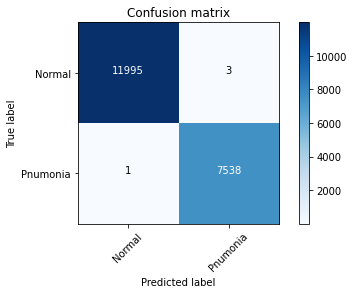

In [ ]:
cm2 = confusion_matrix(inception_y ,inception_preds )
plot_confusion_matrix(cm2,["Normal","Pnumonia"] )

#model can distinguish phonemon vs normal better than covid19 distinguish

### Passing False Positives from Phase-1 to Phase-2 model

In [ ]:
FN_x, FN_y = data_constructor(fnames_test,classes_test, DIM , index  =index_02 , bboxes = bboxes_test)
FN_x = tf.keras.applications.inception_v3.preprocess_input(FN_x)
FN_x.shape , FN_y.shape

((261, 128, 128, 3), (261,))

## CONFUSION MATRIX of False Positives of Phase-1

[[  0   0   0]
 [  0   0   0]
 [ 71 190   0]]


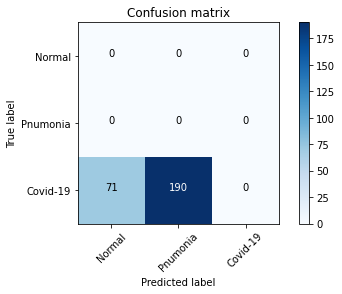

In [ ]:
FN_preds = phase2_model.predict(FN_x)
FN_preds = np.rint(FN_preds).astype("int")
FN_preds = FN_preds.reshape(len(index_02))
cm3 = confusion_matrix(FN_y,FN_preds)
plot_confusion_matrix(cm3,["Normal","Pnumonia","Covid-19"] )

## FINAL CONFUSION MATRIX OF ALL 3 CLASSES

[[11995     3   119]
 [    1  7538    32]
 [   71   190  5709]]


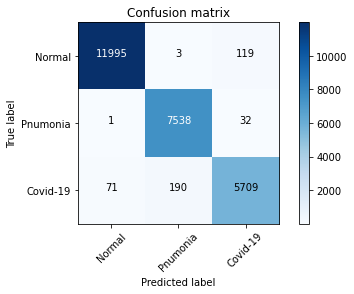

In [ ]:
cm =[[cm2[0,0] , cm2[0,1] , len(index_20)],
    [cm2[1,0] , cm2[1,1] , len(index_21)],
    [cm3[2,0] , cm3[2,1] , cm1[1,1]]]
cm = np.array(cm)
plot_confusion_matrix(cm,["Normal","Pnumonia","Covid-19"] )

## FINAL ACCURACY

In [ ]:
final_accuracy = (cm[0,0]+cm[1,1]+cm[2,2]) / np.sum(cm)
print("Final Accuracy = ""{:.2%}".format(final_accuracy))

Final Accuracy = 98.38%
